 apply "superstatistical" analysis ( https://www.nature.com/articles/ncomms8516#Sec19 ) to walking/crawling modes


In [1]:
# Our data is appropriate for this analysis because the walking/crawling transition comes with a sharp change in persistance of the trajectory
# Currently we do our best to roughly identify walking and crawling using aspect ratio
# be careful doing heavy calculations in the juptyer notebook, we only have 32GB RAM!!


In [2]:
import sys, os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import plotutils
import _fj
import shapeplot
import twanimation


In [3]:
# load fanjin data
debug = False
N = 100 if debug else None
crawling_idx, crawling_trs = _fj.slicehelper.load_linearized_trs('default_crawling_list', N)
walking_idx, walking_trs = _fj.slicehelper.load_linearized_trs('default_walking_list', N)
all_idx = np.concatenate([crawling_idx, walking_idx])
all_trs = crawling_trs + walking_trs
print()
print("loaded {} crawling tracks".format(crawling_idx.size))
print("loaded {} walking tracks".format(walking_idx.size))
print("total {} tracks".format(len(all_trs)))


100%|██████████| 371/371 [00:00<00:00, 4374.66it/s]
loaded 2505 crawling tracks
loaded 371 walking tracks
total 2876 tracks



[(2819, 1.2772638140313313), (2616, 1.2310625008976406), (2645, 1.1280712049849728), (2780, 1.1186056754876224), (2781, 1.0920261316163893), (2733, 0.9962001282977857), (2561, 0.9887861431290762), (2612, 0.9861872583186275), (2704, 0.9809593508171984), (2839, 0.9734234522886134)]


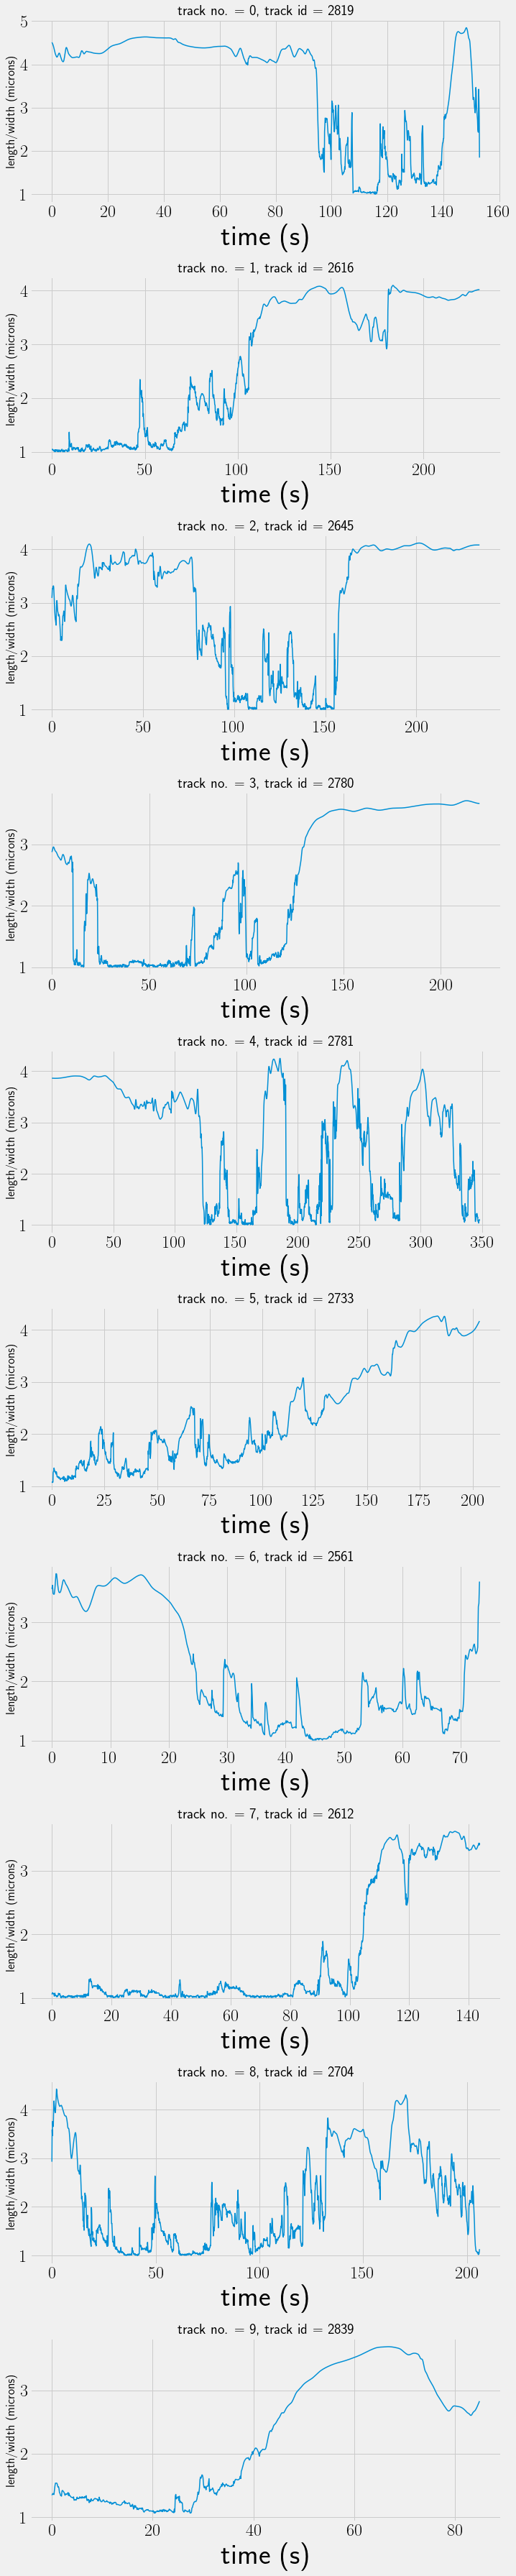

In [4]:
# search all the tracks for some which show clear steps in aspect ratio
whaspect = [tr['length']/tr['width'] for tr in all_trs]
whaspect_std = [np.std(whaspect_i) for whaspect_i in whaspect]
a_sorted = sorted(enumerate(whaspect_std), key=lambda t:t[1], reverse=True)
print(a_sorted[:10])
n = 10
fig, axes = plt.subplots(n,1, figsize=(10,n*5))
for i, (track_i, std) in enumerate(a_sorted[:n]):
    ax = axes[i]
    ax.set_title(r'track no. = {}, track id = {}'.format(i, track_i))
    whaspect_i = whaspect[track_i]
    ax.plot(0.1 * np.arange(whaspect_i.size),  whaspect_i)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('length/width (microns)', fontsize='large')
plt.tight_layout()
plt.show()


In [5]:
# and now we need to familiarise ourselves with the code given by
# https://www.nature.com/articles/ncomms8516#Sec19
sys.path.insert(0, os.path.abspath('tools/'))
import bayesloop
analyser = bayesloop.BayesLoop()
print('The default limits on q and a are respectively, ', analyser.qBound, analyser.aBound)
print(analyser.aBound)
print(analyser.qBound)
# where the limits on q are expected to be [-1, 1] so its not entirely clear why [-1.5,1.5] is used
print('Default control parameters.')
print('pmin = {}'.format(analyser.pMin))
print('Box kernel halfwidths (Ra, Rq) = ({}, {})'.format(analyser.Ra, analyser.Rq))
print('default gridsize =', analyser.gridSize)
print('kernal size is in the context of gridsize and the limits so in fact kernel dimensions are ({},{})'.format(
    2 * analyser.Ra * (analyser.aBound[1]-analyser.aBound[0])/analyser.gridSize,
    2 * analyser.Rq * (analyser.qBound[1]-analyser.qBound[0])/analyser.gridSize
   ))


The default limits on q and a are respectively,  [-1.5, 1.5] [0.0, 3.0]
[0.0, 3.0]
[-1.5, 1.5]
Default control parameters.
pmin = 1e-07
Box kernel halfwidths (Ra, Rq) = (2, 2)
default gridsize = 200
kernal size is in the context of gridsize and the limits so in fact kernel dimensions are (0.06,0.06)


In [6]:
# lets pick track #2 to work with because it appears to switch to walking and back
sorted_pick_id = 2
eye_track_id, eye_track_std  = a_sorted[sorted_pick_id]
eye_data_id = all_idx[eye_track_id]
print('track data id =', eye_data_id) 
eye_track = all_trs[eye_track_id]

track data id = 1279


  0%|          | 0/235 [00:00<?, ?it/s]Constructing Iterators
Computing Axes Limits
num. frames  235
saving animation to plots/animate_outline_1279.mp4
100%|██████████| 235/235 [00:13<00:00, 17.59it/s]


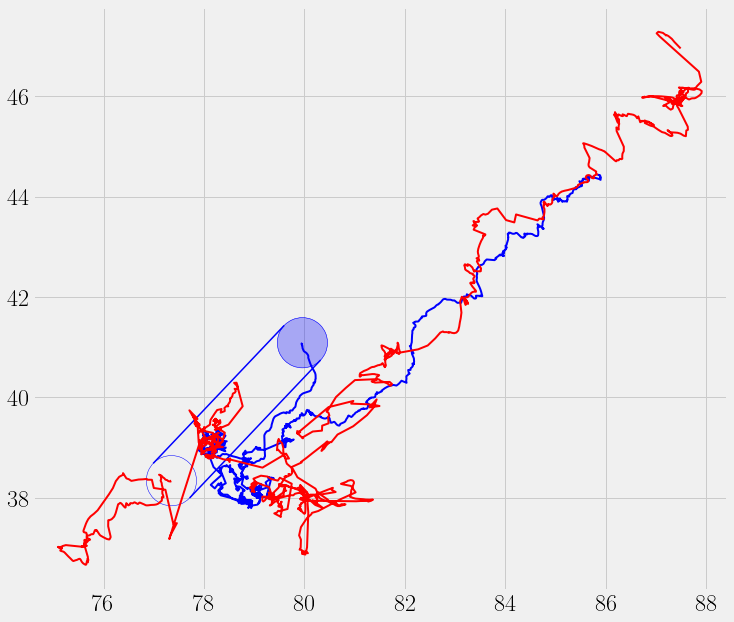

In [7]:
# lets pick track #2 to work with because it appears to switch to walking and back
# animate the trajectory to check it looks resonable
savefile = 'plots/animate_outline_{:04d}.mp4'.format(eye_data_id)
twanimation.outline(plt.gcf(), [eye_track], sample=10, savefile=savefile)


drawing shapes for track 0
attempt to draw 18 cell outlines


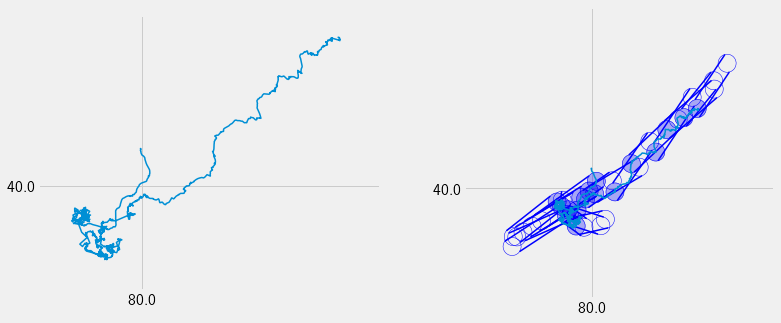

In [8]:
# also plot this track 
fig, axes = plt.subplots(1,2, figsize=(12, 5))
ax1, ax2 = axes
shapeplot.longtracks(ax1, [eye_track])
shapeplot.ltdraw(ax2, [eye_track], sample=100)
plt.show()

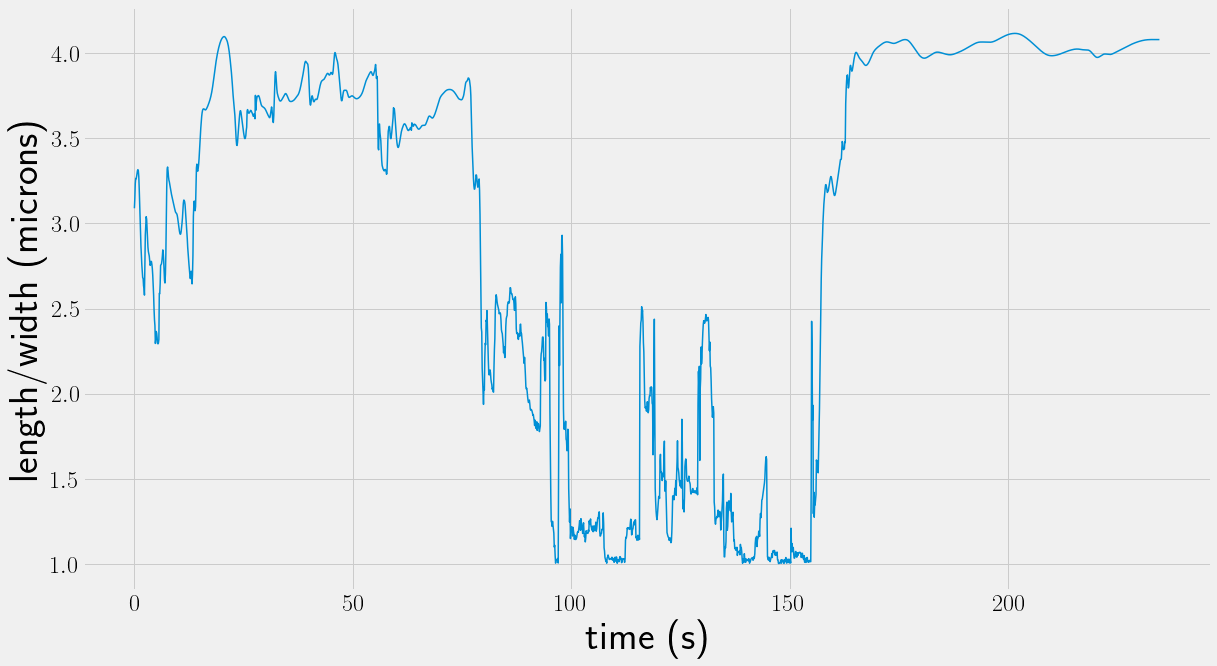

In [9]:
# And again for reference, plot apsect ratio
ax = plt.gca()
eye_track_aspect = whaspect[eye_track_id]
ax.plot(0.1 * np.arange(eye_track_aspect.size),  eye_track_aspect)
ax.set_xlabel('time (s)')
ax.set_ylabel('length/width (microns)')
plt.show()

In [10]:
# and velocity so that we know if the bacterium stops moving


In [11]:
# xy data
trackxy = np.column_stack([ eye_track['x'], eye_track['y'] ])
print('check xy data shape ', trackxy.shape)
print('write out this data so we can check it against the GUI tool')
target = 'tools/trackxy_{:04d}.dat'.format(eye_data_id)
print('writing track {:04d} to {}'.format(eye_data_id, target))
np.savetxt(target, trackxy)


check xy data shape  (2347, 2)
write out this data so we can check it against the GUI tool
writing track 1279 to tools/trackxy_1279.dat


In [12]:
# setup and run the analysis
# analysis takes velocity data
fjtimestep = 0.1
track_u = (trackxy[1:] - trackxy[:-1])/fjtimestep
speed = np.linalg.norm(track_u, axis=1)
print('velocity lims ({},{})'.format(speed.min(), speed.max()))
analyser.data = track_u
analyser.startAnalysis()


velocity lims (0.003507260036561447,5.4121842490008625)
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...


(2, 2345)
(200, 200)


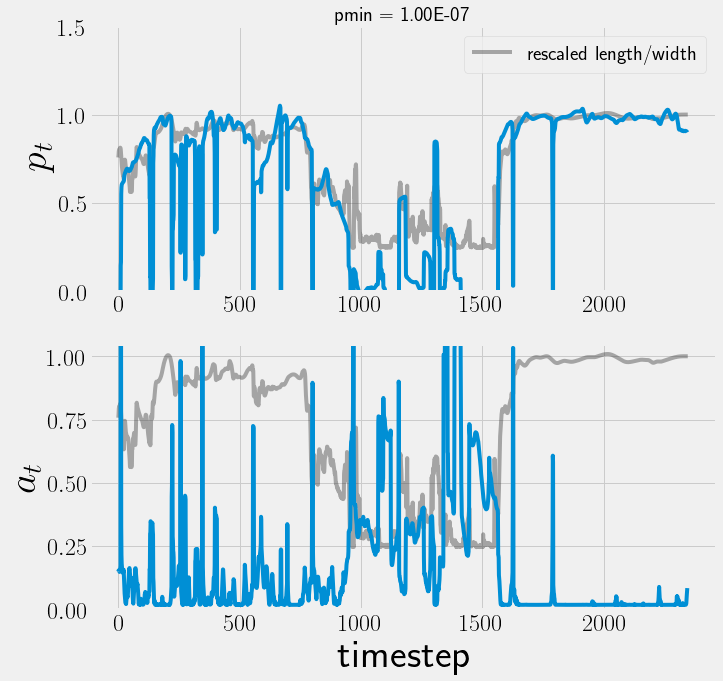

In [13]:
# 
# mean parameters postMean 
print(analyser.postMean.shape)
print(analyser.avgPost.shape)
# rescale eye_track_aspect to [0,1]
rescale = 1/np.quantile(eye_track_aspect, 0.95)
aspect_ghost = rescale * eye_track_aspect
kwghost = {'linewidth':4, 'color':'0.2', 'alpha':0.4}
linekw = {'linewidth':4}

fig, axes = plt.subplots(2,1, figsize=(10,2*5))
def plot_qa(axes, analyser, aspect_ghost=aspect_ghost):
    ax1, ax2 = axes
    q_mean, a_mean = analyser.postMean
    # ax1.axhline(rescale, linewidth=1, c='k', alpha=0.6, linestyle='--')
    ax2.set_xlabel('timestep')
    ax1.plot(aspect_ghost, label='rescaled length/width', **kwghost)
    ax2.plot(aspect_ghost, **kwghost)
    ax1.set_title('pmin = {:.2E}'.format(analyser.pMin))
    ax1.set_ylim((0,1.5))
    ax1.plot(q_mean, **linekw)
    ax1.set_ylabel(r'$p_t$')
    ax2.set_ylim(ymin=0.0)
    ax2.plot(a_mean, label='a parameter', **linekw)
    ax2.set_ylabel(r'$a_t$')
    ax1.legend()
plot_qa(axes, analyser)
plt.show()



In [14]:
# looks like we are quite sensitiive to noise so we should reduce pmin
pmin_try = [1e-9, 1e-12, 1e-15, 1e-18, 1e-21]
save_analyser = []
for pmin in pmin_try:
    print('setting pMin = {} ...'.format(pmin))
    analyser.pMin = pmin
    analyser.startAnalysis()
    del analyser.postSequ
    save_analyser.append(deepcopy(analyser))

setting pMin = 1e-09 ...
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
setting pMin = 1e-12 ...
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
setting pMin = 1e-15 ...
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
setting pMin = 1e-18 ...
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
setting pMin = 1e-21 ...
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...


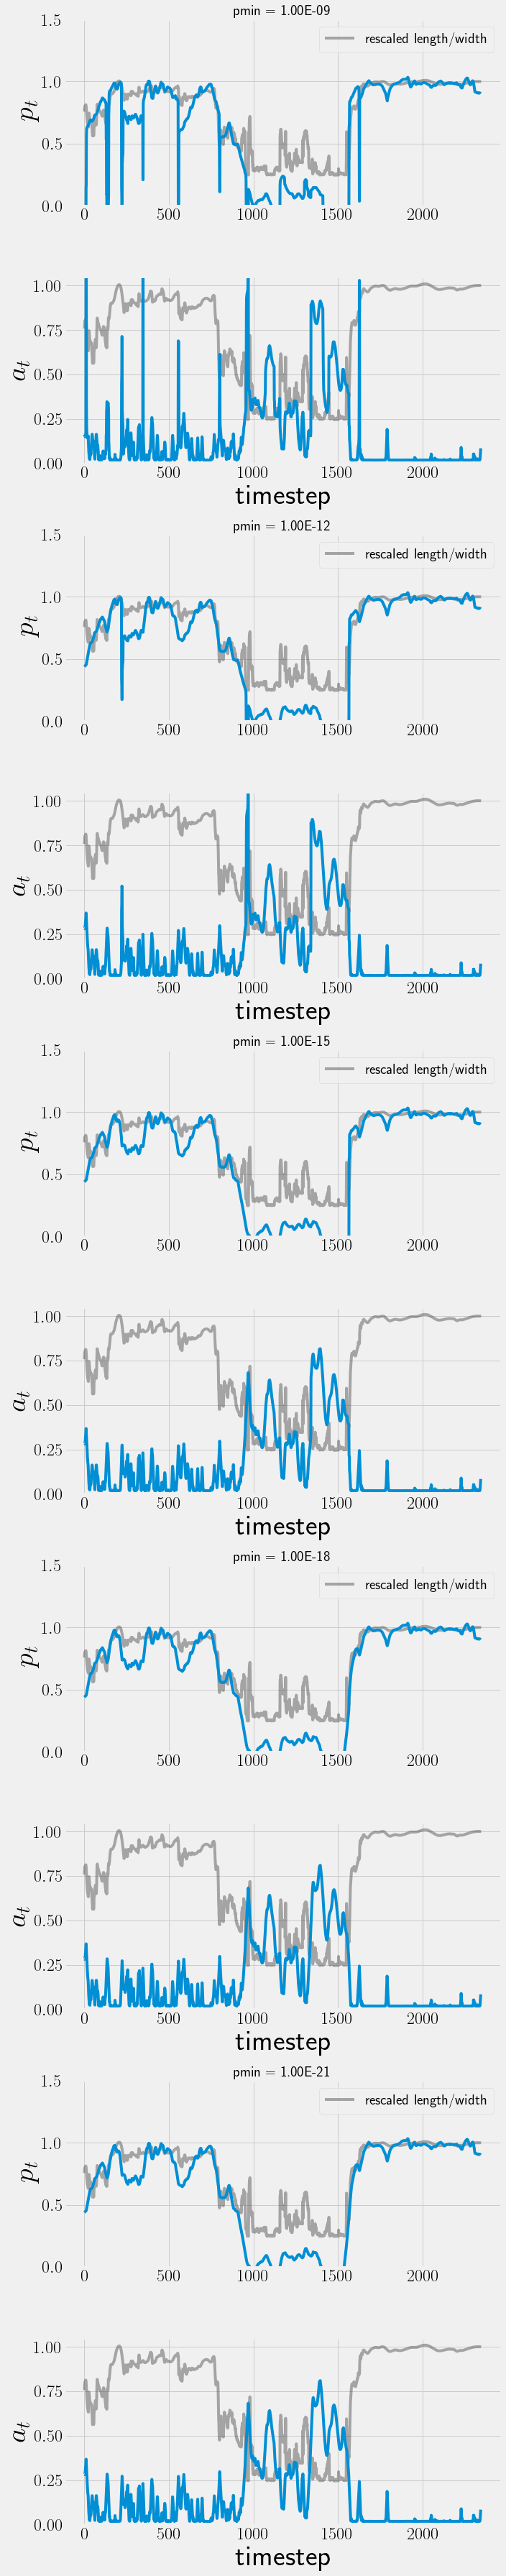

In [15]:
# plotting goes in a new cell

n = len(save_analyser)
fig, axes = plt.subplots(2*n,1, figsize=(10,n*2*5))
for i, analyser in enumerate(save_analyser):
    ax_pair = (axes[2*i], axes[2*i+1])
    plot_qa(ax_pair, analyser)
plt.tight_layout()
plt.show()

# https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots
# if we want to try drawing lines between these subplot pairs


 lets consider the track we picked as the test data set and use it to set control parameters
 then see how well the analysis works on some blind data. Lets select data randomly from
 the walking, crawling and high std deviataion datasets

In [16]:
# first of all let 'high' standard deviation be the top 10% of tracks sorted that way
high_std = a_sorted[:int(all_idx.size/10)+1]
high_std_dataset = [all_idx[track_id] for track_id, std in high_std]
print('high velocity std dataset {:d} tracks'.format(len(high_std_dataset)))
# check how closely this set overlaps with walking dataset
overlap = np.intersect1d(high_std_dataset, walking_idx)
print('of which {:d} are in the walking set which means {:d} are in the crawling set'.format(
    len(overlap), len(high_std_dataset)-len(overlap)))

# remove the track we chose from this dataset
eye_data_idx = np.where(high_std_dataset==eye_data_id)[0][0]
high_std_dataset = np.delete(high_std_dataset, eye_data_idx)

# pull n random tracks from each dataset
# use reproducible random numbers
rg = np.random.default_rng(0)
n = 4
crawling_test_set = rg.choice(crawling_idx, n, replace=False)
walking_test_set = rg.choice(walking_idx, n, replace=False)
# should we exlude these from the high std test set so that all test tracks are unique? 
# I will not exclude them.
high_std_test_set = rg.choice(high_std_dataset, n, replace=False)

test_set = {
    'crawling': crawling_test_set.tolist(),
    'walking': walking_test_set.tolist(),
    'high_std': high_std_test_set.tolist(),
}
test_track_id = {}
for k, idx_list in test_set.items():
    test_track_id[k] = []
    for idx in idx_list:
        track_id = np.where(all_idx==idx)[0][0]
        test_track_id[k].append(int(track_id))

import json
print(json.dumps(test_set, indent=1))
# print(json.dumps(test_track_id, indent=1))


high velocity std dataset 288 tracks
of which 174 are in the walking set which means 114 are in the crawling set
{
 "crawling": [
  858,
  1579,
  2641,
  1940
 ],
 "walking": [
  35,
  2590,
  389,
  2186
 ],
 "high_std": [
  159,
  1569,
  1683,
  1222
 ]
}


In [17]:
# set control parameters
# this takes a really long time
analyser.pMin = 1e-15
# compute for each trajectory
save_set_analyser = {}
for set_name, setidx in test_set.items():
    print('compute q,a for {} test set'.format(set_name))
    save_set_analyser[set_name] = []
    for idx in setidx:
        track_id = np.where(all_idx==idx)[0][0]
        track = all_trs[track_id]
        print('analysing track ', idx, 'with track id', track_id, 'No. steps ', track.size)
        trackxy = np.column_stack([ track['x'], track['y'] ])
        track_u = (trackxy[1:] - trackxy[:-1])/fjtimestep
        analyser.data = track_u
        analyser.startAnalysis()
        # cut down on data usage by deleting the posterior sequence [shape = (n,gridsize,gridsize)]
        del analyser.postSequ
        save_set_analyser[set_name].append(deepcopy(analyser))




compute q,a for crawling test set
analysing track  858 with track id 675 No. steps  19999
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
analysing track  1579 with track id 1279 No. steps  19999
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
analysing track  2641 with track id 2128 No. steps  3533
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
analysing track  1940 with track id 1594 No. steps  6669
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
compute q,a for walking test set
analysing track  35 with track id 2511 No. steps  19999
build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
analysing track  2590 with track id 2805 No. steps  1895
build parameter grid...
Computin

In [18]:
# grab the rescaled aspect ratio time series
test_set_aspect = {}
for k, track_id_list in test_track_id.items():
    test_set_aspect[k] = []
    for track_id in track_id_list:
        this_whaspect = whaspect[track_id]
        rescale = 1/np.quantile(this_whaspect, 0.95)
        rescaled_aspect = rescale * this_whaspect
        test_set_aspect[k].append( rescaled_aspect )


crawling test set
track data id =  858
track data id =  1579
track data id =  2641
track data id =  1940


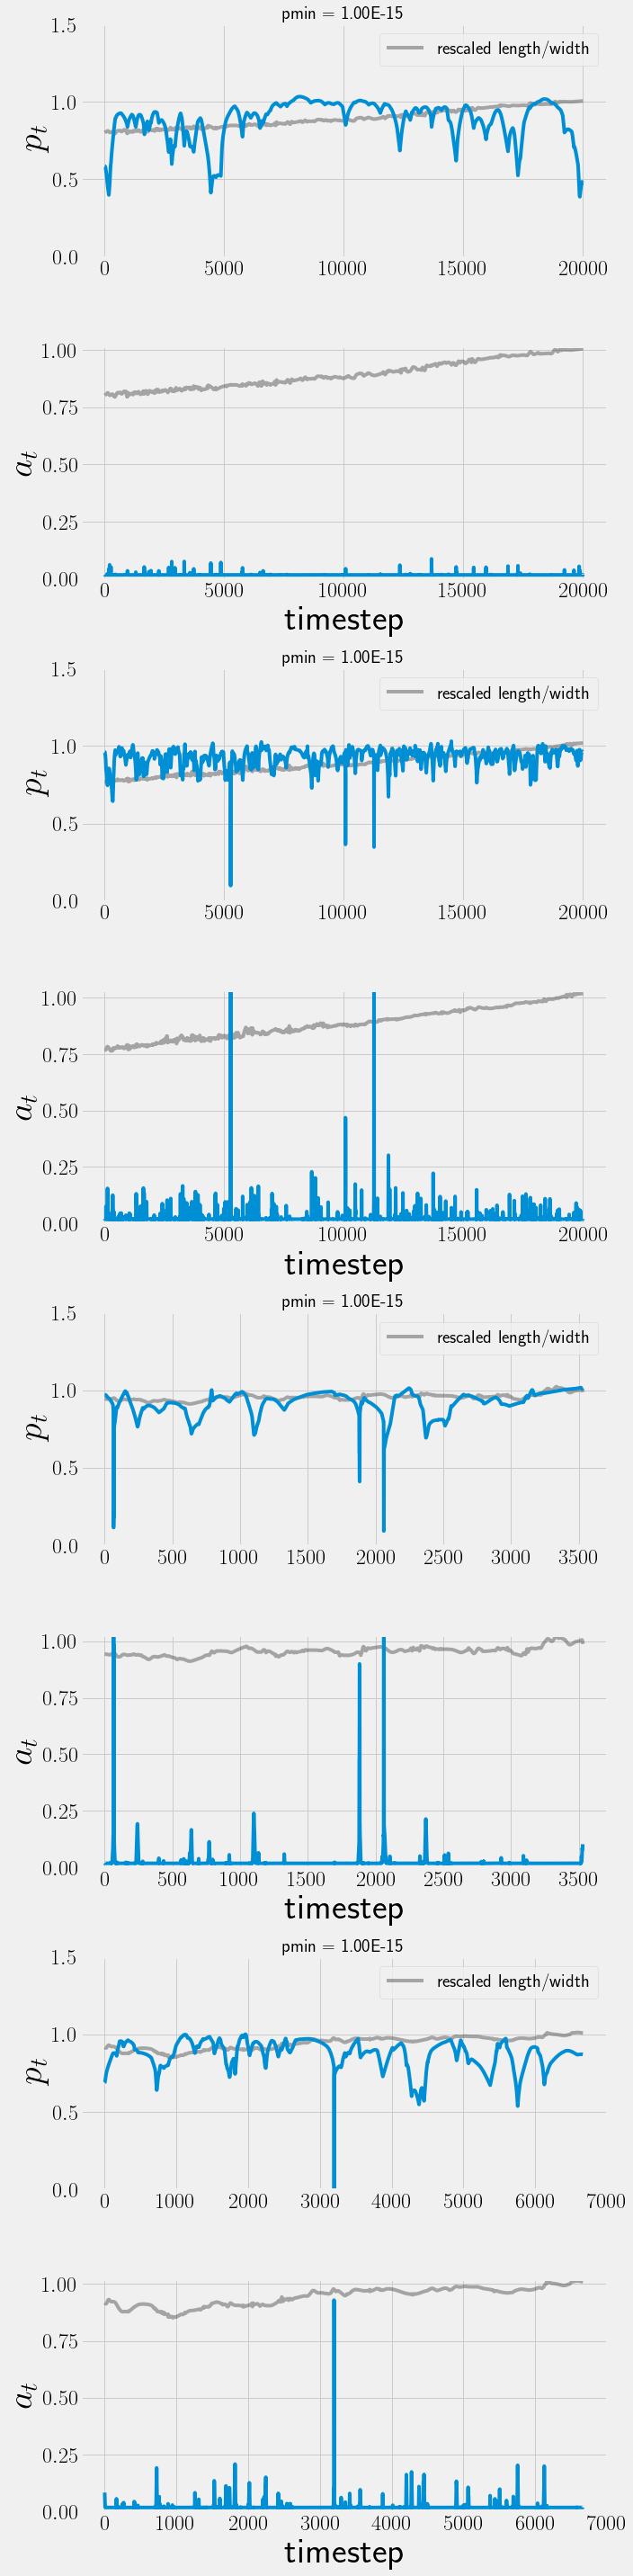

In [19]:
# now plot for each dataset so we can see by eye if persistance/activity are correlated with aspect ratio
print('crawling test set')
def plot_test_set(set_name):
    fig, axes = plt.subplots(2*4,1, figsize=(10,4*2*5))
    for i, data_id in enumerate(test_set[set_name]):
        aspect_ghost = test_set_aspect[set_name][i]
        print('track data id = ', data_id)
        analyser = save_set_analyser[set_name][i]
        ax_pair = (axes[2*i], axes[2*i+1])
        plot_qa(ax_pair, analyser, aspect_ghost=aspect_ghost)
plot_test_set('crawling')
plt.tight_layout()
plt.show()


walking test set
track data id =  35
track data id =  2590
track data id =  389
track data id =  2186


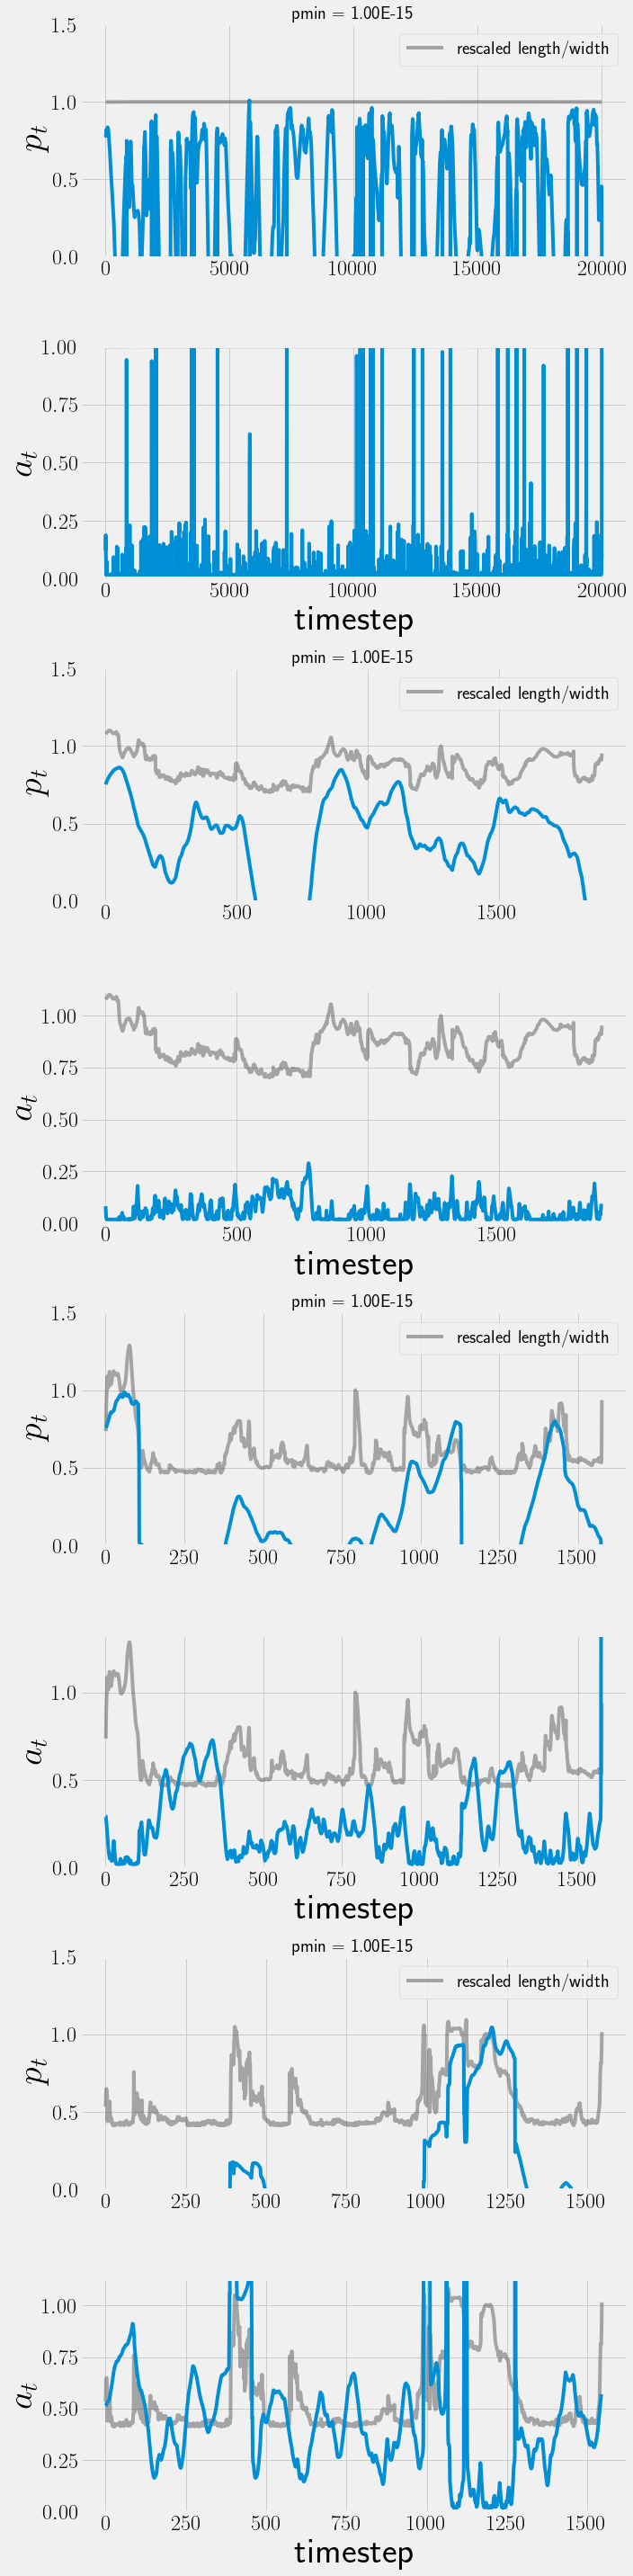

In [20]:
print('walking test set')
plot_test_set('walking')
plt.tight_layout()
plt.show()


high velocity std test set
track data id =  159
track data id =  1569
track data id =  1683
track data id =  1222


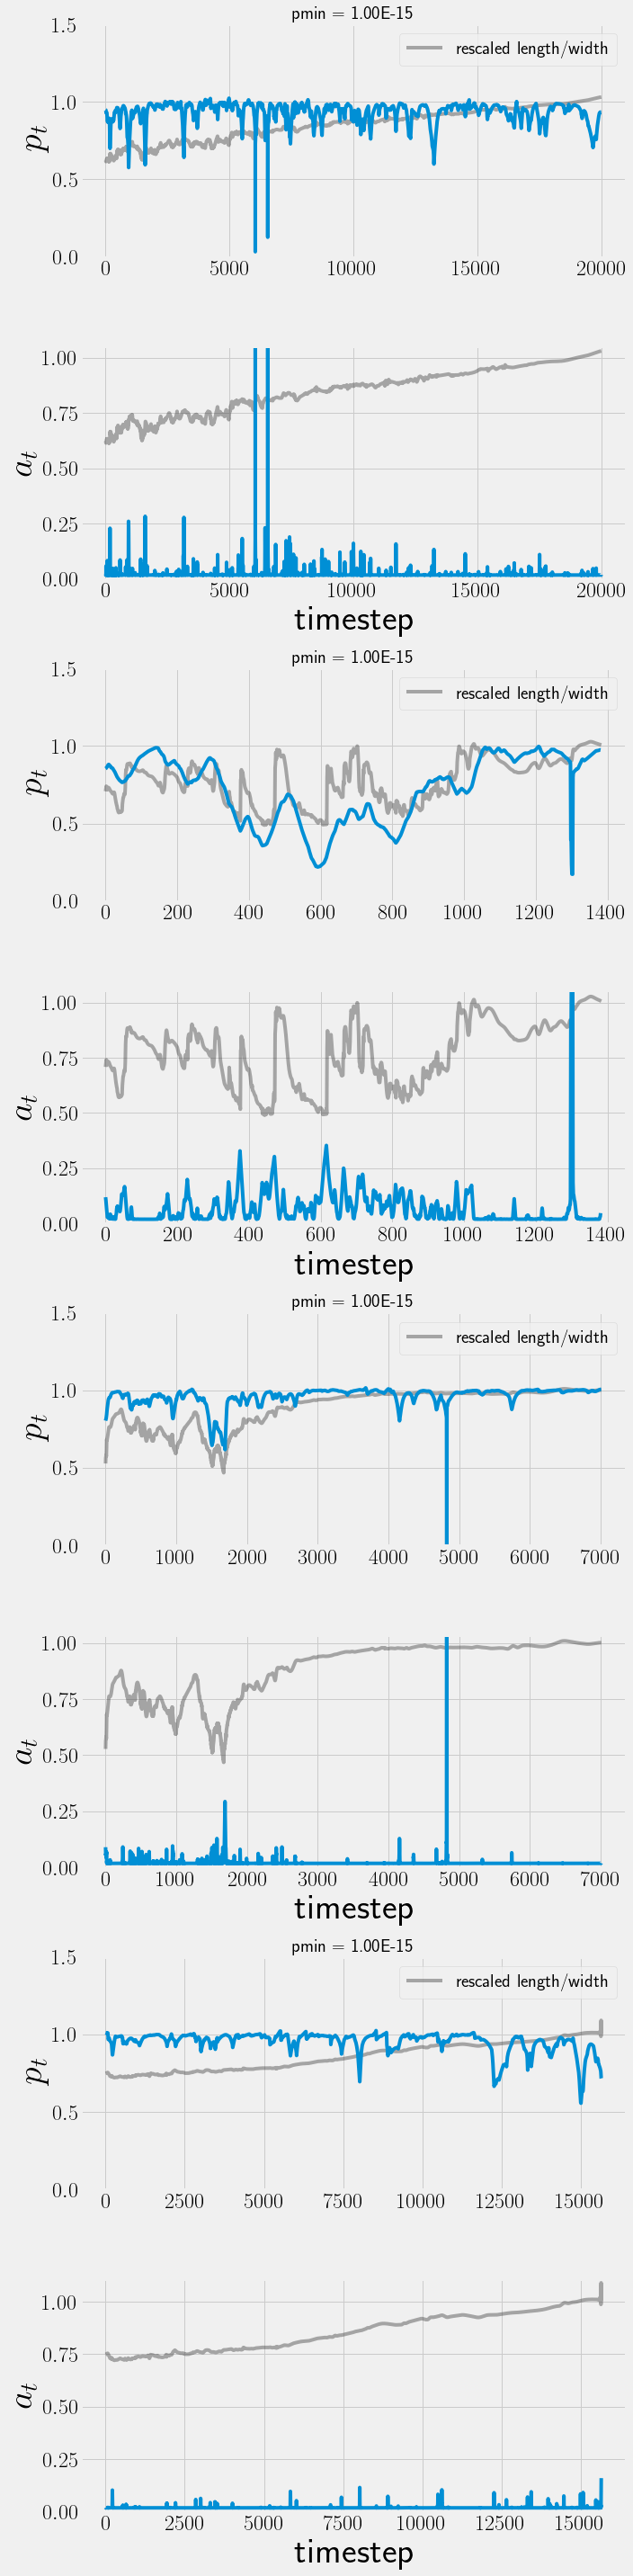

In [21]:
print('high velocity std test set')
plot_test_set('high_std')
plt.tight_layout()
plt.show()


 looking at this sample we see that we might want to adjust pMin to be a little smaller
 also we can generally see some correlation between aspect ratio and persistance